# HVM Overview: The Hybrid Vitrimer Model

## Introduction

**Vitrimers** (Montarnal et al., 2011) are a revolutionary class of polymer networks that
combine the mechanical integrity of thermosets with the reprocessability of thermoplastics.
Their unique property is **associative bond exchange reactions (BER)**: covalent bonds
rearrange their topology without ever breaking the network, enabling stress relaxation
while preserving crosslink density.

The **Hybrid Vitrimer Model (HVM)** provides a constitutive framework for these materials,
built on the VLB transient network theory (Vernerey, Long & Brighenti, 2017). It captures
the interplay between permanent, exchangeable, and dissociative subnetworks through a
tensorial formulation with Transition State Theory (TST) kinetics.

> **Handbook:** For the complete mathematical formulation, see the
> [HVM Model Reference](../../docs/source/models/hvm/hvm.rst). For the underlying
> transient network theory, see the [VLB Foundation](../../docs/source/models/vlb/vlb.rst).

## Learning Objectives

- Understand the 3-subnetwork architecture (Permanent + Exchangeable + Dissociative)
- Explore the vitrimer signature: evolving natural-state tensor $\mu^E_{nat}$
- Demonstrate quick SAOS fitting with NLSQ
- Compare limiting cases via factory methods
- Visualize Arrhenius temperature dependence

## Model Features

- Permanent covalent crosslinks ($G_P$)
- Exchangeable vitrimer bonds with TST kinetics ($G_E$, $k_{BER}$)
- Optional dissociative physical bonds ($G_D$)
- Factor-of-2 in $\tau_{E,eff}$: both $\mu^E$ and $\mu^E_{nat}$ relax toward each other
- $\sigma_E \to 0$ at steady state (natural state tracks deformation)

## Notebook Series

| Notebook | Protocol | Method | Key Result |
|:---|:---|:---|:---|
| **01** SAOS | Oscillation | Analytical | Two Maxwell modes + $G_P$ plateau |
| **02** Relaxation | Step strain | ODE | Bi-exponential + plateau |
| **03** Startup | Constant rate | ODE | TST stress overshoot |
| **04** Creep | Constant stress | ODE | Vitrimer plastic flow |
| **05** Flow curve | Steady state | Analytical | $\sigma_E = 0$, subnetwork decomposition |
| **06** LAOS | Large oscillation | ODE | Harmonic generation from TST |
| **08-13** | All protocols | NLSQ + NUTS | Full Bayesian inference pipeline |

## 1. Setup

In [1]:
%matplotlib inline
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, str(Path("..").resolve()))
from utils.hvm_data import check_data_quality, load_epstein_saos
from utils.hvm_fit import FAST_MODE, get_output_dir, save_figure

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import HVMLocal

jax, jnp = safe_import_jax()
verify_float64()

print(f"FAST_MODE: {FAST_MODE}")
output_dir = get_output_dir("hvm")
print(f"Output directory: {output_dir}")
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

FAST_MODE: True
Output directory: /Users/b80985/Projects/rheojax/examples/outputs/hvm/hvm


## 2. Model Architecture

The HVM combines three subnetworks:

1. **Permanent (P)**: Covalent crosslinks, neo-Hookean elasticity, stress σ_P = G_P·(μ - I)
2. **Exchangeable (E)**: Vitrimer bonds with Bond Exchange Reactions (BER)
   - Evolving natural-state tensor: dμ^E_nat/dt = 2·k_BER·(μ^E - μ^E_nat)
   - Actual deformation tensor: dμ^E/dt = κ·μ^E + μ^E·κ^T - 2·k_BER·(μ^E - μ^E_nat)
   - Stress σ_E = G_E·(μ^E - μ^E_nat) → 0 at steady state
   - TST kinetics: k_BER = ν₀·exp(-E_a/RT)·cosh(V_act·σ_VM/RT)
3. **Dissociative (D)**: Physical bonds, Maxwell-like relaxation, stress σ_D = G_D·μ^D

**Key insight**: The factor-of-2 in τ_E_eff = 1/(2·k_BER_0) accounts for both μ^E and μ^E_nat relaxing toward each other.

In [2]:
# Create full HVM with all 3 subnetworks
model = HVMLocal(include_dissociative=True, kinetics="stress")

print("HVM Parameters:")
for param_name in model.parameters.keys():
    param = model.parameters[param_name]
    print(f"  {param_name}: {param.value:.4g} {param.units} - {param.description}")

print("\nDefault Network Fractions:")
G_P = model.parameters.get_value("G_P")
G_E = model.parameters.get_value("G_E")
G_D = model.parameters.get_value("G_D")
G_total = G_P + G_E + G_D
print(f"  Permanent:     {G_P/G_total:.2%}")
print(f"  Exchangeable:  {G_E/G_total:.2%}")
print(f"  Dissociative:  {G_D/G_total:.2%}")

HVM Parameters:
  G_P: 1e+04 Pa - Permanent network modulus
  G_E: 1e+04 Pa - Exchangeable network modulus
  nu_0: 1e+10 1/s - TST attempt frequency
  E_a: 8e+04 J/mol - Activation energy for BER
  V_act: 1e-05 m^3/mol - Activation volume
  T: 300 K - Temperature
  G_D: 1000 Pa - Dissociative network modulus
  k_d_D: 1 1/s - Dissociative rate

Default Network Fractions:
  Permanent:     47.62%
  Exchangeable:  47.62%
  Dissociative:  4.76%


## 3. Quick SAOS Demo

Fit SAOS data from Epstein et al.'s vitrimer network. The HVM should capture:
- High-frequency plateau from G_P (permanent crosslinks)
- Two Maxwell modes (τ_E from exchangeable, τ_D from dissociative)
- Terminal flow region from bond exchange

In [3]:
# Load Epstein SAOS data
omega, G_prime_data, G_double_prime_data = load_epstein_saos()
G_star = np.sqrt(G_prime_data**2 + G_double_prime_data**2)

print(f"Data shape: {omega.shape}")
print(f"Frequency range: {omega.min():.4g} to {omega.max():.4g} rad/s")

# Quality check
check_data_quality(omega, G_star, "Epstein SAOS |G*|")

Data shape: (19,)
Frequency range: 0.1008 to 99.42 rad/s
Data QC: Epstein SAOS |G*|
  Points: 19
  x range: [0.1008, 99.42]
  y range: [29, 3674]
  Status: PASSED


{'name': 'Epstein SAOS |G*|',
 'n_points': 19,
 'x_range': (0.10078333, 99.41878208),
 'y_range': (29.002020743396468, 3674.3190242163078),
 'has_nan': False,
 'has_inf': False,
 'all_positive_y': True,
 'monotonic_x': True,
 'issues': [],
 'passed': True}

In [4]:
# NLSQ fit
model_fit = HVMLocal(include_dissociative=True, kinetics="stress")
model_fit.parameters.set_value("T", 300.0)  # Fix temperature (not measured)

# Set initial parameters appropriate for Epstein data range (~30-3600 Pa)
model_fit.parameters.set_value("G_P", 50.0)
model_fit.parameters.set_value("G_E", 300.0)
model_fit.parameters.set_value("G_D", 200.0)
model_fit.parameters.set_value("k_d_D", 5.0)
model_fit.parameters.set_value("nu_0", 1e8)
model_fit.parameters.set_value("E_a", 50e3)

print("Running NLSQ fit...")
model_fit.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
r_sq = getattr(model_fit._nlsq_result, 'r_squared', None) if model_fit._nlsq_result else None
print(f"R² = {r_sq:.6f}" if r_sq is not None else "R² = N/A")

print("\nFitted parameters:")
for param_name in model_fit.parameters.keys():
    if param_name != "T":
        print(f"  {param_name}: {model_fit.parameters.get_value(param_name):.4g}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=8 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Running NLSQ fit...


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=9.924188s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=1718 | final_cost=0.0063 | elapsed=9.924s | final_gradient_norm=98.8536


R² = N/A

Fitted parameters:
  G_P: 21.61
  G_E: 373.7
  nu_0: 9.495e+07
  E_a: 4.99e+04
  V_act: 0.00995
  G_D: 3272
  k_d_D: 40.7


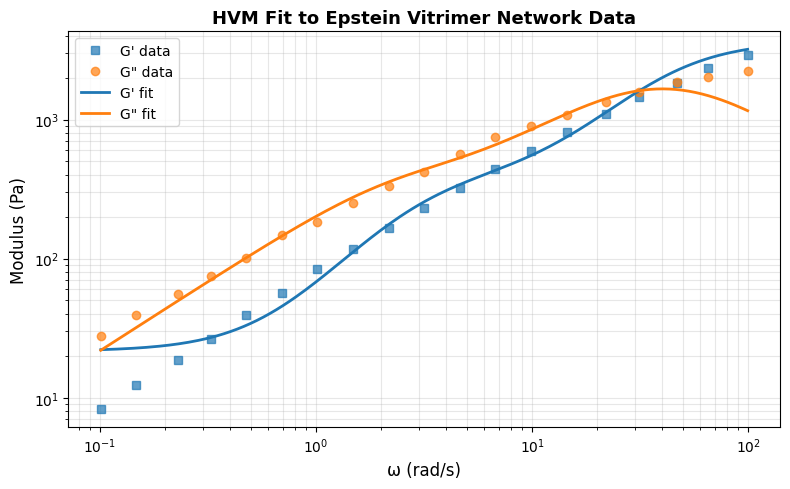

Figure saved: /Users/b80985/Projects/rheojax/examples/outputs/hvm/hvm/figures/quick_saos_fit.png


In [5]:
# Plot data vs fit
omega_fit = np.logspace(np.log10(omega.min()), np.log10(omega.max()), 200)
G_p_fit, G_dp_fit = model_fit.predict_saos(omega_fit)

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(omega, G_prime_data, 's', markersize=6, color='C0', label="G' data", alpha=0.7)
ax.loglog(omega, G_double_prime_data, 'o', markersize=6, color='C1', label='G" data', alpha=0.7)
ax.loglog(omega_fit, G_p_fit, '-', linewidth=2, color='C0', label="G' fit")
ax.loglog(omega_fit, G_dp_fit, '-', linewidth=2, color='C1', label='G" fit')
ax.set_xlabel("ω (rad/s)", fontsize=12)
ax.set_ylabel("Modulus (Pa)", fontsize=12)
ax.set_title("HVM Fit to Epstein Vitrimer Network Data", fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which='both')
plt.tight_layout()
display(fig)
save_figure(fig, output_dir, "quick_saos_fit.png")
plt.close(fig)

## 4. Relaxation Spectrum

The HVM has a discrete relaxation spectrum with two Maxwell modes:

**Mode 1 (Exchangeable):**
- τ_E_eff = 1/(2·k_BER_0) — factor of 2 from mutual relaxation
- G_E modulus

**Mode 2 (Dissociative):**
- τ_D = 1/k_d_D — standard Maxwell relaxation
- G_D modulus

**High-frequency plateau:**
- G_∞ = G_P (permanent crosslinks)

In [6]:
# Get relaxation spectrum from fitted model
spectrum = model_fit.get_relaxation_spectrum()

print("Relaxation Spectrum (modulus, relaxation_time):")
for i, (G_i, tau_i) in enumerate(spectrum):
    if tau_i == float('inf'):
        print(f"  Permanent (P): G = {G_i:.4g} Pa, τ = ∞")
    else:
        print(f"  Mode {i}: G = {G_i:.4g} Pa, τ = {tau_i:.4g} s, k = {1/tau_i:.4g} s⁻¹")

# Verify factor-of-2
nu_0 = model_fit.parameters.get_value("nu_0")
E_a = model_fit.parameters.get_value("E_a")
T = model_fit.parameters.get_value("T")
R = 8.314
k_BER_0_direct = nu_0 * np.exp(-E_a / (R * T))
tau_E_eff_expected = 1 / (2 * k_BER_0_direct)
# Find E-network mode (finite tau, not D-network)
e_modes = [(G, t) for G, t in spectrum if t != float('inf') and t > 0.1]
if e_modes:
    tau_E_measured = e_modes[0][1]
    print(f"\nFactor-of-2 verification:")
    print(f"  τ_E_eff (from spectrum) = {tau_E_measured:.4g} s")
    print(f"  τ_E_eff (from 1/(2·k_BER_0)) = {tau_E_eff_expected:.4g} s")
    print(f"  Match: {abs(tau_E_measured - tau_E_eff_expected)/tau_E_eff_expected < 0.01}")

Relaxation Spectrum (modulus, relaxation_time):
  Permanent (P): G = 21.61 Pa, τ = ∞
  Mode 1: G = 373.7 Pa, τ = 0.3677 s, k = 2.72 s⁻¹
  Mode 2: G = 3272 Pa, τ = 0.02457 s, k = 40.7 s⁻¹

Factor-of-2 verification:
  τ_E_eff (from spectrum) = 0.3677 s
  τ_E_eff (from 1/(2·k_BER_0)) = 0.368 s
  Match: True


## 5. Factory Methods: Limiting Cases

The HVM provides factory methods to create limiting cases:

1. **neo_hookean**: Only permanent network (G_E = G_D = 0)
2. **maxwell**: Only dissociative network (G_P = G_E = 0)
3. **zener**: Permanent + dissociative (G_E = 0)
4. **pure_vitrimer**: Permanent + exchangeable (G_D = 0)
5. **partial_vitrimer**: All three networks (full HVM)

We'll compare G'(ω) for these cases with matched total modulus.

In [7]:
# Create limiting cases
G_total = 1e5  # 100 kPa total modulus
tau_relax = 10.0  # 10 s relaxation time

# 1. Neo-Hookean (pure elastic)
neo_hook = HVMLocal.neo_hookean(G_P=G_total)

# 2. Maxwell (pure viscous)
maxwell = HVMLocal.maxwell(G_D=G_total, k_d_D=1/tau_relax)

# 3. Zener (elastic + viscous)
zener = HVMLocal.zener(G_P=0.5*G_total, G_D=0.5*G_total, k_d_D=1/tau_relax)

# 4. Pure Vitrimer (elastic + exchangeable, no dissociative)
pure_vit = HVMLocal.pure_vitrimer(
    G_E=0.5*G_total, 
    nu_0=1e10, 
    E_a=80e3,
    T=300.0
)

# 5. Full HVM (all three networks)
full_hvm = HVMLocal(include_dissociative=True)
full_hvm.parameters.set_value("G_P", 0.33*G_total)
full_hvm.parameters.set_value("G_E", 0.33*G_total)
full_hvm.parameters.set_value("G_D", 0.34*G_total)
full_hvm.parameters.set_value("k_d_D", 1/tau_relax)
full_hvm.parameters.set_value("nu_0", 1e10)
full_hvm.parameters.set_value("E_a", 80e3)
full_hvm.parameters.set_value("T", 300.0)

print("Limiting cases created successfully.")

Limiting cases created successfully.


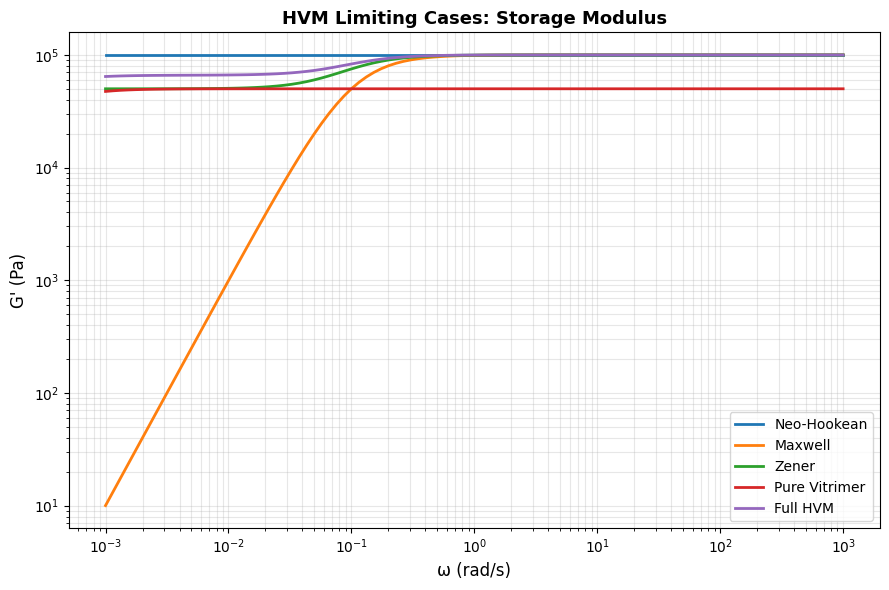

Figure saved: /Users/b80985/Projects/rheojax/examples/outputs/hvm/hvm/figures/limiting_cases_comparison.png

Key observations:
- Neo-Hookean: Constant G' (pure elastic)
- Maxwell: G' ~ ω² at low ω (viscous liquid)
- Zener: Plateau + relaxation (standard viscoelastic solid)
- Pure Vitrimer: Similar to Zener but with evolving natural state
- Partial Vitrimer: Two relaxation modes visible


In [8]:
# Compute G'(ω) for all cases
omega_test = np.logspace(-3, 3, 100)

models = {
    "Neo-Hookean": neo_hook,
    "Maxwell": maxwell,
    "Zener": zener,
    "Pure Vitrimer": pure_vit,
    "Full HVM": full_hvm
}

fig, ax = plt.subplots(figsize=(9, 6))

for name, m in models.items():
    G_p, G_dp = m.predict_saos(omega_test)
    ax.loglog(omega_test, G_p, linewidth=2, label=name)

ax.set_xlabel("ω (rad/s)", fontsize=12)
ax.set_ylabel("G' (Pa)", fontsize=12)
ax.set_title("HVM Limiting Cases: Storage Modulus", fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3, which='both')
plt.tight_layout()
display(fig)
save_figure(fig, output_dir, "limiting_cases_comparison.png")
plt.close(fig)

print("\nKey observations:")
print("- Neo-Hookean: Constant G' (pure elastic)")
print("- Maxwell: G' ~ ω² at low ω (viscous liquid)")
print("- Zener: Plateau + relaxation (standard viscoelastic solid)")
print("- Pure Vitrimer: Similar to Zener but with evolving natural state")
print("- Partial Vitrimer: Two relaxation modes visible")

## 6. Arrhenius Temperature Dependence

The exchangeable network relaxation time follows Arrhenius behavior:

$$k_{BER}(T) = \nu_0 \exp\left(-\frac{E_a}{RT}\right)$$

$$\tau_E(T) = \frac{1}{2 k_{BER}(T)} = \frac{1}{2\nu_0} \exp\left(\frac{E_a}{RT}\right)$$

This gives the vitrimer topology freezing transition temperature T_v.

In [9]:
# Temperature sweep
T_range = np.linspace(250, 400, 50)  # 250-400 K
nu_0 = model_fit.parameters.get_value("nu_0")
E_a = model_fit.parameters.get_value("E_a")
R = 8.314  # J/(mol·K)

k_BER_T = nu_0 * np.exp(-E_a / (R * T_range))
tau_E_T = 1 / (2 * k_BER_T)

# Find T_v (where τ_E = 100 s, typical experimental timescale)
tau_experimental = 100.0  # s
T_v = E_a / (R * np.log(2 * nu_0 * tau_experimental))

print(f"Fitted Arrhenius parameters:")
print(f"  ν₀ = {nu_0:.4g} s⁻¹")
print(f"  E_a = {E_a/1e3:.2f} kJ/mol")
print(f"\nTopology freezing transition:")
print(f"  T_v = {T_v:.1f} K = {T_v-273.15:.1f} °C (at τ_E = 100 s)")

Fitted Arrhenius parameters:
  ν₀ = 9.495e+07 s⁻¹
  E_a = 49.90 kJ/mol

Topology freezing transition:
  T_v = 253.6 K = -19.5 °C (at τ_E = 100 s)


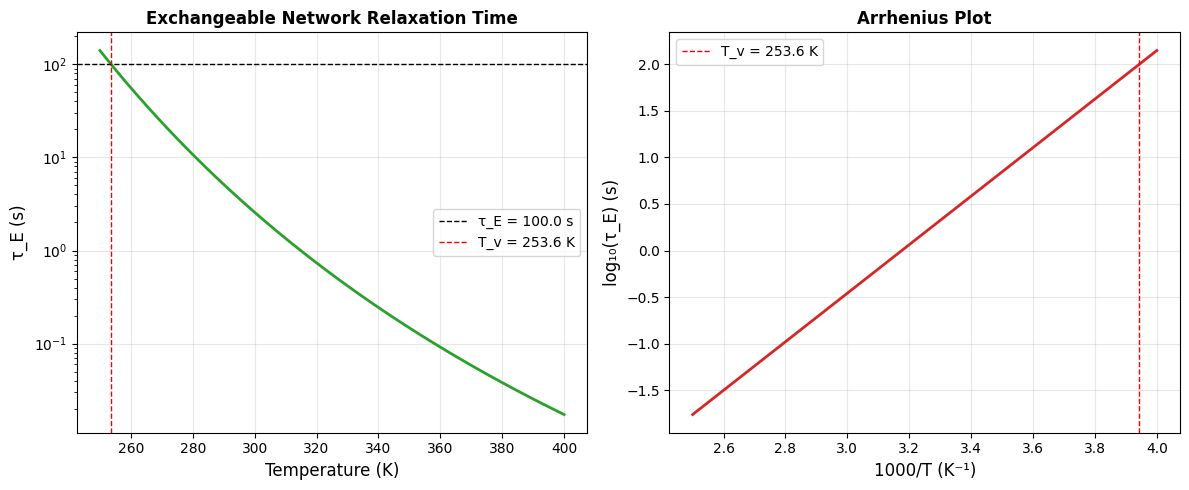

Figure saved: /Users/b80985/Projects/rheojax/examples/outputs/hvm/hvm/figures/arrhenius_temperature_dependence.png


In [10]:
# Arrhenius plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left: τ_E vs T
ax1.semilogy(T_range, tau_E_T, linewidth=2, color='C2')
ax1.axhline(tau_experimental, color='k', linestyle='--', linewidth=1, label=f'τ_E = {tau_experimental} s')
ax1.axvline(T_v, color='r', linestyle='--', linewidth=1, label=f'T_v = {T_v:.1f} K')
ax1.set_xlabel("Temperature (K)", fontsize=12)
ax1.set_ylabel("τ_E (s)", fontsize=12)
ax1.set_title("Exchangeable Network Relaxation Time", fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right: Arrhenius plot (log τ_E vs 1/T)
ax2.plot(1000/T_range, np.log10(tau_E_T), linewidth=2, color='C3')
ax2.axvline(1000/T_v, color='r', linestyle='--', linewidth=1, label=f'T_v = {T_v:.1f} K')
ax2.set_xlabel("1000/T (K⁻¹)", fontsize=12)
ax2.set_ylabel("log₁₀(τ_E) (s)", fontsize=12)
ax2.set_title("Arrhenius Plot", fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
save_figure(fig, output_dir, "arrhenius_temperature_dependence.png")
plt.close(fig)

## 7. Where to Go Next

This overview demonstrated the HVM architecture and key features. The remaining notebooks provide detailed workflows:

1. **`hvm_01_flow_curve.ipynb`** - Steady-state flow curve
   - Yield stress behavior
   - Component decomposition

2. **`hvm_02_creep.ipynb`** - J(t) compliance
   - Elastic + viscous contributions
   - Steady-state viscosity

3. **`hvm_03_relaxation.ipynb`** - G(t) with multi-mode spectrum
   - Natural-state tensor tracking

4. **`hvm_04_startup.ipynb`** - Startup shear overshoot
   - TST kinetics effects
   - Shear rate dependence

5. **`hvm_05_saos.ipynb`** - Full Bayesian SAOS inference
   - NLSQ → NUTS workflow
   - ArviZ diagnostics + posterior predictive

6. **`hvm_06_laos.ipynb`** - Large amplitude oscillatory shear
   - Lissajous curves
   - Harmonic analysis

Each notebook uses **real experimental data** with full Bayesian inference (NLSQ → NumPyro NUTS).

## Summary

**Key Takeaways:**
- HVM combines permanent, exchangeable, and dissociative networks
- Vitrimer signature: evolving natural-state tensor $\mu^E_{nat}$
- Factor-of-2 in $\tau_{E,eff}$ from mutual relaxation
- $\sigma_E \to 0$ at steady state (natural state tracks deformation)
- Arrhenius temperature dependence with $T_v$ topology freezing transition
- Factory methods provide limiting cases for validation

## Further Reading

**Handbook documentation:**
- [HVM Model Reference](../../docs/source/models/hvm/hvm.rst) — Constitutive equations and notation
- [HVM Protocol Derivations](../../docs/source/models/hvm/hvm_protocols.rst) — Step-by-step derivations
- [HVM Knowledge Extraction](../../docs/source/models/hvm/hvm_knowledge.rst) — Fitting strategy and diagnostics
- [HVM Advanced Theory](../../docs/source/models/hvm/hvm_advanced.rst) — Thermodynamic framework

**Key references:**
1. Montarnal, D. et al. (2011). *Science*, 334, 965-968.
2. Vernerey, F.J., Long, R. & Brighenti, R. (2017). *J. Mech. Phys. Solids*, 107, 1-20.
3. Meng, F., Saed, M.O. & Terentjev, E.M. (2019). *Macromolecules*, 52(19), 7423-7429.